## POS tagging using modified Viterbi

**Problem statement:**
<n>Modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques
    
**Goals:**
1. **Write** the **vanilla Viterbi** algorithm for assigning POS tags.
2. **Solve** the problem of unknown words **using** at least **two techniques.**
3. **Compare** the tagging **accuracy** after making these modifications with the vanilla Viterbi algorithm.
4. **List down** at least **3 cases** from the sample test file which were **incorrectly tagged** by the original Viterbi.

### Data Preparation

In [1]:
#Importing libraries
import nltk, pprint, re
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# samples: Each sentence is a list of (word, pos) tuples
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
#Test-Train split test - 5%, train - 95% as given in problem statement
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=100)
print(len(train_set))
print(len(test_set))

3718
196


In [5]:
# converting the list of sents to a list of (word, pos tag) tuples in train_set
tagged_words_train = [w for s in train_set for w in s]
print(len(tagged_words_train))
tagged_words_train[:10]

95949


[('One', 'NUM'),
 ('bright', 'ADJ'),
 ('sign', 'NOUN'),
 ('is', 'VERB'),
 ('that', 'ADP'),
 ('a', 'DET'),
 ('growing', 'VERB'),
 ('number', 'NOUN'),
 ('of', 'ADP'),
 ('women', 'NOUN')]

In [6]:
# converting the list of sents to a list of (word, pos tag) tuples in train_set
tagged_words_test = [w for s in test_set for w in s]
print(len(tagged_words_test))
tagged_words_test[:10]

4727


[('Investors', 'NOUN'),
 ('took', 'VERB'),
 ('advantage', 'NOUN'),
 ('of', 'ADP'),
 ('Tuesday', 'NOUN'),
 ("'s", 'PRT'),
 ('stock', 'NOUN'),
 ('rally', 'NOUN'),
 ('*-1', 'X'),
 ('to', 'PRT')]

In [7]:
#separating Words and Tags
words = [pair[0] for pair in tagged_words_train]
w = set(words)
tags = [pair[1] for pair in tagged_words_train]
t = set(tags)

In [8]:
print(len(w))
print(len(t))

12106
12


In [9]:
print(t)

{'DET', 'ADV', '.', 'PRON', 'X', 'ADP', 'ADJ', 'NOUN', 'PRT', 'CONJ', 'NUM', 'VERB'}


### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [10]:
#the probability of the word for a given tag
# we will calculate number of times the word occuring, #tags occuring and # word given the tag occuring
def Emission(word, tag, train_bag = tagged_words_train):
    words = [pair for pair in train_bag if pair[0]==word]
    count_word = len(words)
    tags = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tags)
    words_given_tag = [pair[0] for pair in tags if pair[0]==word]
    count_words_given_tag = len(words_given_tag)
    (w,t,w_t) = (count_word, count_tag,count_words_given_tag)
    
    print("count of " + str(word) + " = " + str(w))
    print("count of " + str(tag) + " = " + str(t))
    print("number of times " + str(word) + " is tagged as " +str(tag)+ " = " + str(w_t))
    return(w,t,w_t)

In [11]:
def emission(word, tag, train_bag = tagged_words_train):
    tags = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tags)
    words_given_tag = [pair[0] for pair in tags if pair[0]==word]
    count_words_given_tag = len(words_given_tag)
    return(count_tag, count_words_given_tag)

In [12]:
Emission('years', 'NOUN')

count of years = 106
count of NOUN = 27539
number of times years is tagged as NOUN = 106


(106, 27539, 106)

#### Transition Probabilities

In [13]:
#the probability of tag1 followed by tag2
# we will calculate number of times tag1 occuring tag2 occuring and tag1 followed by tag2
def Transition(t1, t2, train_bag = tagged_words_train):
    tag1 = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    tag2 = [pair[1] for pair in train_bag]
    count_t2 = len([t for t in tags if t==t2])
    count_t2_t1 = 0
    for index in range(len(tag1)-1):
        if tag1[index]==t1 and tag1[index+1] == t2:
            count_t2_t1 += 1
    (x,y,t1_t2) = (count_t1,count_t2,count_t2_t1)
    print("count of " + str(t1) + " = " + str(x)),
    print("count of " + str(t2) + " = " + str(y)),
    print("number of times " + str(t1) + " is followed by " +str(t2)+ " = " + str(t1_t2))
    return (x,y,t1_t2)

In [14]:
def transition(t1, t2, train_bag = tagged_words_train):
    tag1 = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tag1)-1):
        if tag1[index]==t1 and tag1[index+1] == t2:
            count_t2_t1 += 1
    return(count_t1,count_t2_t1)

In [15]:
Transition("ADJ",'NOUN')

count of ADJ = 6105
count of NOUN = 27539
number of times ADJ is followed by NOUN = 4279


(6105, 27539, 4279)

In [16]:
Transition('DET','.')

count of DET = 8318
count of . = 11149
number of times DET is followed by . = 149


(8318, 11149, 149)

In [17]:
#Creating a matrix for all the transitions possible
tags_matrix = np.zeros((len(t), len(t)), dtype='float32')
for i, t1 in enumerate(list(t)):
    for j, t2 in enumerate(list(t)): 
        tags_matrix[i, j] = transition (t1, t2)[1]/transition (t1, t2)[0]

In [18]:
#represting in dataframe form
tags_df = pd.DataFrame(tags_matrix, columns = list(t), index=list(t))
tags_df

,DET,ADV,.,PRON,X,ADP,ADJ,NOUN,PRT,CONJ,NUM,VERB
DET,0.005771,0.012623,0.017913,0.003727,0.045323,0.009618,0.204977,0.637293,0.000240,0.000481,0.021640,0.040394
ADV,0.069907,0.077230,0.135153,0.015646,0.023302,0.119507,0.130160,0.031624,0.014314,0.006991,0.031624,0.344541
.,0.173558,0.052292,0.092923,0.065208,0.026908,0.092206,0.043681,0.222531,0.002511,0.058032,0.081353,0.088708
PRON,0.009195,0.034100,0.040613,0.007663,0.092720,0.023372,0.072031,0.211494,0.012261,0.004981,0.007280,0.484291
X,0.055229,0.025393,0.162831,0.055705,0.074433,0.144898,0.016505,0.062371,0.184891,0.010316,0.002857,0.204571
ADP,0.323969,0.013357,0.039754,0.069119,0.034984,0.017492,0.107389,0.321213,0.001484,0.000848,0.061910,0.008481
ADJ,0.004914,0.004914,0.063882,0.000491,0.020311,0.078624,0.067158,0.700901,0.010156,0.016052,0.020803,0.011794
NOUN,0.013363,0.016813,0.239951,0.004721,0.028868,0.177058,0.012165,0.264280,0.043357,0.042921,0.009550,0.146955
PRT,0.101050,0.010171,0.043635,0.017717,0.013123,0.019357,0.083661,0.245735,0.001969,0.002297,0.056102,0.405184
CONJ,0.118683,0.053778,0.035698,0.058414,0.008809,0.053778,0.118683,0.350487,0.003709,0.000464,0.042188,0.155308


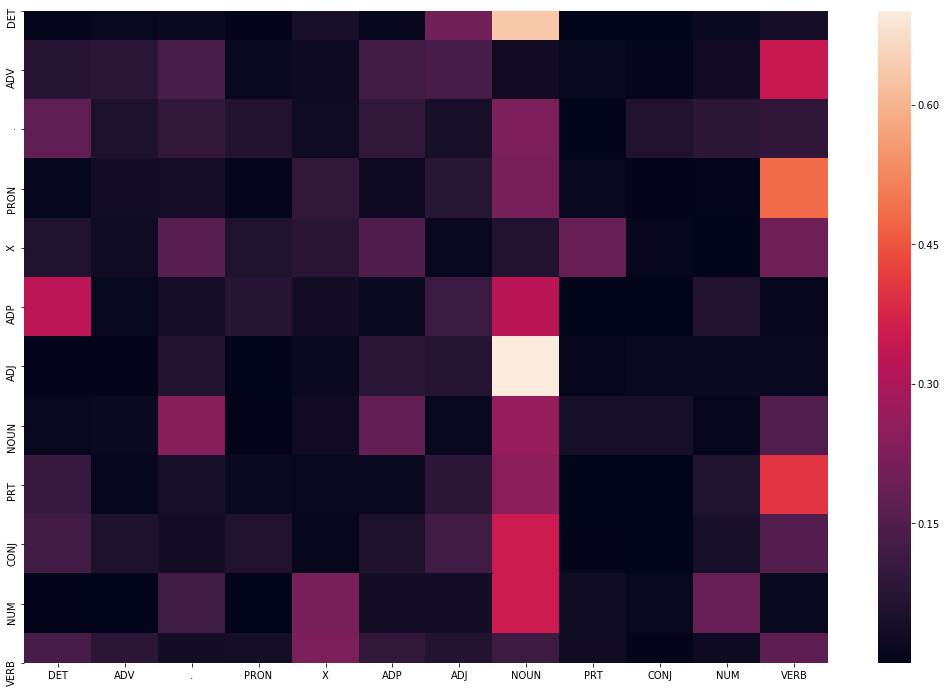

In [19]:
#heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

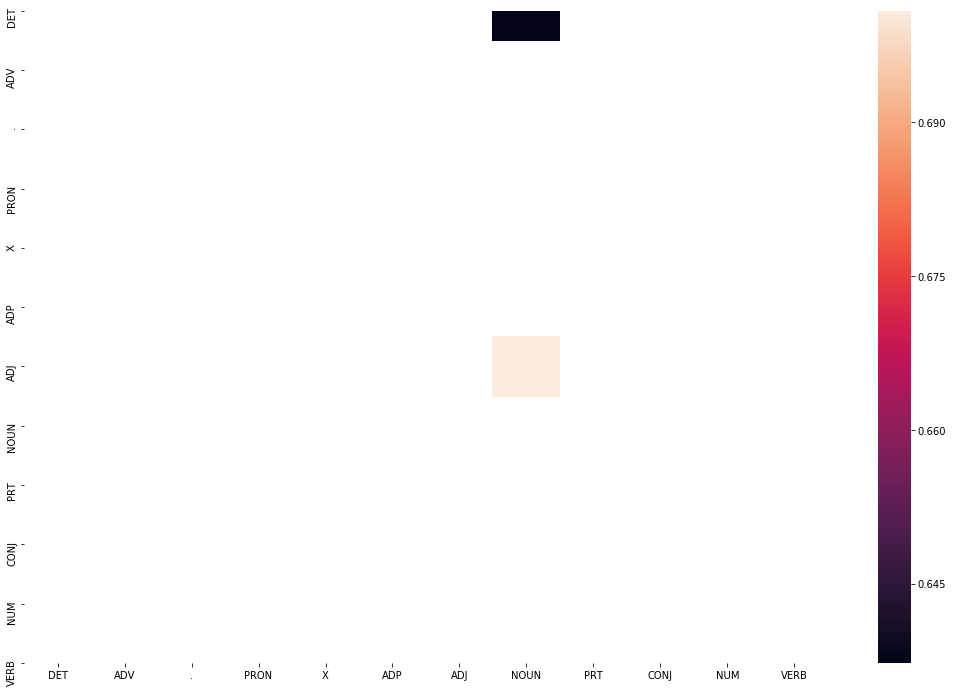

In [20]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [21]:
# now viterbi algorithm
# Viterbi Heuristic
def vanillaviterbi(words, train_bag = tagged_words_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission(words[key], tag)[1]/emission(words[key], tag)[0]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [22]:
Testword = [word[0] for sentence in test_set for word in sentence]

In [23]:
start = time.time()
tagged_seq = vanillaviterbi(Testword)
end = time.time()
difference = end-start

In [24]:
# accuracy
check = [i for i, j in zip(tagged_seq, tagged_words_test) if i == j] 

In [25]:
accuracy = len(check)/len(tagged_seq)

In [26]:
print(accuracy*100)
print(difference)

90.35328961286227
733.1587150096893


In [27]:
incorrect_tagged_cases = [[tagged_words_test[i-1],j] for i, j in enumerate(zip(tagged_seq, tagged_words_test)) if j[0]!=j[1]]

In [28]:
incorrect_tagged_cases

[[('to', 'PRT'), (('book', 'NOUN'), ('book', 'VERB'))],
 [('leaving', 'VERB'), (('stocks', 'NOUN'), ('stocks', 'ADV'))],
 [('stocks', 'ADV'), (('up', 'PRT'), ('up', 'ADP'))],
 [('carried', 'VERB'), (('over', 'ADP'), ('over', 'PRT'))],
 [('apparently', 'ADV'), (('ignored', 'DET'), ('ignored', 'VERB'))],
 [('Chilean', 'ADJ'), (('mine', 'NOUN'), ('mine', 'ADJ'))],
 [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))],
 [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('.', '.'), (('Preston', 'DET'), ('Preston', 'NOUN'))],
 [('Foster', 'NOUN'), (('Birmingham', 'DET'), ('Birmingham', 'NOUN'))],
 [(',', '.'), (('Ala', 'DET'), ('Ala', 'NOUN'))],
 [('has', 'VERB'), (('clamped', 'DET'), ('clamped', 'VERB'))],
 [('their', 'PRON'), (('ankle', 'DET'), ('ankle', 'NOUN'))],
 [('the', 'DET'), (('third-largest', 'DET'), ('third-largest', 'ADJ'))],
 [('the', 'DET'), (('fifth-largest', 'DET'), ('fifth-largest', 'ADJ'))],
 [('Charles', 'NOUN'), (('Z.', 'DET'), ('Z.', 'NOUN'

### Solve the problem of unknown words

#### Modification 1

__** problem statement: Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? **__

In [29]:
# so lets look at most commonly occuring tag and use it for the unknown words
def tagcount(t1, train_bag = tagged_words_train):
    tag = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tag if t==t1])
    return count_t1

In [30]:
tagcount("NOUN")

27539

In [31]:
x = list(t)
temp = [tagcount(i) for i in x]
temp

[8318, 3004, 11149, 2610, 6301, 9433, 6105, 27539, 3048, 2157, 3366, 12919]

In [32]:
temp_df = pd.DataFrame(temp, columns = ["count"],index=[list(t)])

In [33]:
temp_df

,count
DET,8318
ADV,3004
.,11149
PRON,2610
X,6301
ADP,9433
ADJ,6105
NOUN,27539
PRT,3048
CONJ,2157


**Noun** is the most commonly occuring tag so lets add a function to tag all the unkown words as nouns

In [34]:
def viterbi_modf1(x, train_bag = tagged_words_train):
    tags_seq = vanillaviterbi(x, train_bag)
    a = [pair[0] for pair in tags_seq]
    b = [pair[1] for pair in tags_seq]
    
    for key, word in enumerate(a):
        if word not in w:
            b[key] = 'NOUN'
            
    
    return list(zip(a, b)) 

In [35]:
start = time.time()
seq2 = viterbi_modf1(Testword)
end = time.time()
difference = end-start
seq2

[('Investors', 'NOUN'),
 ('took', 'VERB'),
 ('advantage', 'NOUN'),
 ('of', 'ADP'),
 ('Tuesday', 'NOUN'),
 ("'s", 'PRT'),
 ('stock', 'NOUN'),
 ('rally', 'NOUN'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('book', 'NOUN'),
 ('some', 'DET'),
 ('profits', 'NOUN'),
 ('yesterday', 'NOUN'),
 (',', '.'),
 ('*-1', 'X'),
 ('leaving', 'VERB'),
 ('stocks', 'NOUN'),
 ('up', 'PRT'),
 ('fractionally', 'ADV'),
 ('.', '.'),
 ('Buying', 'VERB'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('most', 'ADJ'),
 ('part', 'NOUN'),
 ('carried', 'VERB'),
 ('over', 'ADP'),
 ('from', 'ADP'),
 ('the', 'DET'),
 ('previous', 'ADJ'),
 ('session', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('traders', 'NOUN'),
 ('apparently', 'ADV'),
 ('ignored', 'NOUN'),
 ('reports', 'NOUN'),
 ('that', 'ADP'),
 ('a', 'DET'),
 ('Chilean', 'ADJ'),
 ('mine', 'NOUN'),
 ('strike', 'NOUN'),
 ('may', 'VERB'),
 ('have', 'VERB'),
 ('ended', 'VERB'),
 ('almost', 'ADV'),
 ('before', 'ADP'),
 ('it', 'PRON'),
 ('began', 'VERB'),
 (',', '.'),
 ('an', 'DET'),
 ('analyst

In [36]:
# accuracy
check = [i for i, j in zip(seq2, tagged_words_test) if i == j]
accuracy = len(check)/len(seq2)
print(accuracy*100)
print(difference)


93.52654960863127
712.4355189800262


In [37]:
incorrect_tagged_cases = [[tagged_words_test[i-1],j] for i, j in enumerate(zip(seq2, tagged_words_test)) if j[0]!=j[1]]

In [38]:
incorrect_tagged_cases

[[('to', 'PRT'), (('book', 'NOUN'), ('book', 'VERB'))],
 [('leaving', 'VERB'), (('stocks', 'NOUN'), ('stocks', 'ADV'))],
 [('stocks', 'ADV'), (('up', 'PRT'), ('up', 'ADP'))],
 [('carried', 'VERB'), (('over', 'ADP'), ('over', 'PRT'))],
 [('apparently', 'ADV'), (('ignored', 'NOUN'), ('ignored', 'VERB'))],
 [('Chilean', 'ADJ'), (('mine', 'NOUN'), ('mine', 'ADJ'))],
 [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))],
 [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('has', 'VERB'), (('clamped', 'NOUN'), ('clamped', 'VERB'))],
 [('the', 'DET'), (('third-largest', 'NOUN'), ('third-largest', 'ADJ'))],
 [('the', 'DET'), (('fifth-largest', 'NOUN'), ('fifth-largest', 'ADJ'))],
 [('#', '.'), (('89.7', 'NOUN'), ('89.7', 'NUM'))],
 [('$', '.'), (('141.9', 'NOUN'), ('141.9', 'NUM'))],
 [('#', '.'), (('94.8', 'NOUN'), ('94.8', 'NUM'))],
 [('$', '.'), (('149.9', 'NOUN'), ('149.9', 'NUM'))],
 [('he', 'PRON'), (('argues', 'NOUN'), ('argues', 'VERB'))],
 [('*', 'X'), ((

#### Modification 2

The idea for modificaation 2 is we will define a set of rules for unknown words using regex tagger
and combine it with unigram and bigram taggers

#### Rulebased or Regex tagger

In [59]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*(ed|ing|es)$', 'VERB'),      # any word ending with ed,es and ing is tagged as verb
    (r'.*ly$', 'ADV'),                               # Adverb ending with 'ly'. 
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),         # Alpha Numeric - ADJ
    (r'.*able$', 'ADJ'),                             # Adjective ending with 'able'. 
    (r'.*ful$', 'ADJ'),                              # Adjective ending with 'ful'. 
    (r'.*ous$', 'ADJ'),                              # Adjective ending with 'ous'. 
    (r'^[aA-zZ].*[0-9]+','NOUN'),                    # Alpha Numeric.
    (r'.*ness$', 'NOUN'),                            # Nouns - words ending with 'ness'.
    (r'.*\'s$', 'NOUN'),                             # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                               # plural nouns.
    (r'.*ers$', 'NOUN'),                             # Nouns ending with 'ers'.
    (r'.*ment$', 'NOUN'),                            # Nouns - words ending with 'ment'.
    (r'.*town$', 'NOUN'),                            # Nouns - words ending with 'town'.
    (r'^(0|([*|-|$].*))','X'),                       # Any special character combination
    (r'.*ould$', 'X'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'),                  # Numbers 
    (r'.*', 'NOUN')                    # nouns
]

In [60]:
regexp_tagger = nltk.RegexpTagger(patterns)

#### Unigram tagger

In [61]:
# Lexicon (or unigram tagger) backedoff by regex tagger
unigram_tagger = nltk.UnigramTagger(train_set,backoff = regexp_tagger)
unigram_tagger.evaluate(test_set)

0.94986249206685

#### Bigram tagger

In [62]:
# bigram tagger backed up by both unigram and regex tagger as mentioned above
def POS_tagger(word, words_set = train_set):
    bigram_tagger = nltk.BigramTagger(train_set, backoff = unigram_tagger)
    return bigram_tagger.tag_sents([[(word)]])

In [63]:
POS_tagger('choked')

[[('choked', 'VERB')]]

#### Veterbi modified by the POS_tagger

In [64]:
def viterbi_ver2(x, train_bag = tagged_words_train):
    tags_seq = vanillaviterbi(x, train_bag)
    a = [pair[0] for pair in tags_seq]
    b = [pair[1] for pair in tags_seq]
    
    for key, word in enumerate(a):
        if word not in w:
            unknown_word_tag = POS_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    b[key] = tup[1]
            
    
    return list(zip(a, b)) 

In [46]:
def viterbi_modf2(sample, train_bag = tagged_words_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(sample):
        if word not in w:
            unknown_word_tag = POS_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = emission(words[key], tag)[1]/emission(words[key], tag)[0]
                state_probability = emission_p * transition_p
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [65]:
start = time.time()
seq3 = viterbi_ver2(Testword)
end = time.time()
difference = end-start
seq3

[('Investors', 'NOUN'),
 ('took', 'VERB'),
 ('advantage', 'NOUN'),
 ('of', 'ADP'),
 ('Tuesday', 'NOUN'),
 ("'s", 'PRT'),
 ('stock', 'NOUN'),
 ('rally', 'NOUN'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('book', 'NOUN'),
 ('some', 'DET'),
 ('profits', 'NOUN'),
 ('yesterday', 'NOUN'),
 (',', '.'),
 ('*-1', 'X'),
 ('leaving', 'VERB'),
 ('stocks', 'NOUN'),
 ('up', 'PRT'),
 ('fractionally', 'ADV'),
 ('.', '.'),
 ('Buying', 'VERB'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('most', 'ADJ'),
 ('part', 'NOUN'),
 ('carried', 'VERB'),
 ('over', 'ADP'),
 ('from', 'ADP'),
 ('the', 'DET'),
 ('previous', 'ADJ'),
 ('session', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('traders', 'NOUN'),
 ('apparently', 'ADV'),
 ('ignored', 'VERB'),
 ('reports', 'NOUN'),
 ('that', 'ADP'),
 ('a', 'DET'),
 ('Chilean', 'ADJ'),
 ('mine', 'NOUN'),
 ('strike', 'NOUN'),
 ('may', 'VERB'),
 ('have', 'VERB'),
 ('ended', 'VERB'),
 ('almost', 'ADV'),
 ('before', 'ADP'),
 ('it', 'PRON'),
 ('began', 'VERB'),
 (',', '.'),
 ('an', 'DET'),
 ('analyst

In [66]:
# accuracy
check = [i for i, j in zip(seq3, tagged_words_test) if i == j]
accuracy = len(check)/len(seq3)
print(accuracy*100)
print(difference)

95.17664480643114
1207.9645051956177


### List down cases which were incorrectly tagged by vanilaviterbi and got corrected by modifications

In [67]:
def comparing(x,y,wordsTag) :
    return [(original,venila,updated) for original,venila,updated in zip(wordsTag,x,y) if (venila != original) & (updated == original) ]

In [70]:
# compared to vanila
comparing_df = pd.DataFrame(set(comparing(tagged_seq,seq3,tagged_words_test)),columns=['Actual Tag','Vanilla','Modified Viterbi'])

In [71]:
comparing_df

,Actual Tag,Vanilla,Modified Viterbi
0,"(non-biodegradable, ADJ)","(non-biodegradable, DET)","(non-biodegradable, ADJ)"
1,"(89.7, NUM)","(89.7, DET)","(89.7, NUM)"
2,"(maturing, VERB)","(maturing, DET)","(maturing, VERB)"
3,"(Tiny, NOUN)","(Tiny, DET)","(Tiny, NOUN)"
4,"(Researchers, NOUN)","(Researchers, DET)","(Researchers, NOUN)"
...,...,...,...
218,"(stemmed, VERB)","(stemmed, DET)","(stemmed, VERB)"
219,"(fifth-largest, ADJ)","(fifth-largest, DET)","(fifth-largest, ADJ)"
220,"(insanity, NOUN)","(insanity, DET)","(insanity, NOUN)"
221,"(attendance, NOUN)","(attendance, DET)","(attendance, NOUN)"


### original tags that which donot match with modified vitrebi

In [72]:
def mismatch(x,wordsTag) :
    return [(original,updated) for original,updated in zip(wordsTag,x) if  (updated != original) ]

In [74]:
mismatch_df = pd.DataFrame(set(mismatch(seq3,tagged_words_test)),columns=['Actual Tag','Modified Viterbi'])

In [75]:
mismatch_df

,Actual Tag,Modified Viterbi
0,"(Indexing, NOUN)","(Indexing, VERB)"
1,"(bid, NOUN)","(bid, VERB)"
2,"(confused, VERB)","(confused, ADJ)"
3,"(appeal, VERB)","(appeal, NOUN)"
4,"(the, NOUN)","(the, DET)"
...,...,...
191,"(following, NOUN)","(following, VERB)"
192,"(Philippine, ADJ)","(Philippine, NOUN)"
193,"(the, NUM)","(the, DET)"
194,"(usurp, VERB)","(usurp, NOUN)"


So there are **196** mismatches, but if you observe in the original tags itself there are some wrong tags, such as, "the" is tagged as "NUM" which is not correct

### Accuary comparision



||Venilla Viterbi|Modified Viterbi|Viterbi with POS_tagger|
| --- | --- | --- | --- |
|Accuracy|90.35%|93.5%|95.17%|


## Testing on the sample test sentences

In [77]:
sample_test_sent = 'Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta. I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
test_words = word_tokenize(sample_test_sent)

start = time.time()
tagged_seq = viterbi_ver2(test_words)
end = time.time()
difference = end-start

In [78]:
tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'VERB'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('